# 1 Author:
- Student Name: **Yuxuan Wang**
- Student ID: **210985403**

# 2 Problem formulation
 We are going to developing an unsupervised learning model that is tasked with identifying the most similar images to a given reference image within the GENKI-4K dataset. To developing an unsupervised learning model that is tasked with identifying the most similar images to a given reference image within the GENKI-4K dataset.
 To enhance the feature extraction process in our unsupervised learning model, we propose the use of a modified VGG network. The traditional VGG architecture, known for its effectiveness in image classification tasks, will be adapted to function as a symmetrical autoencoder. This modification aims to leverage the deep learning capabilities of VGG networks for more robust and nuanced feature extraction, which is critical for measuring image similarity accurately.


# 3 Machine Learning Pipeline
## Input
The input to this pipeline comprises a collection of images from the GENKI-4K dataset. These images, primarily facial photographs, require specific preprocessing to optimize them for feature extraction through the VGG16-based autoencoder.

## Preprocessing and Transformation
We proform data augmentation and normalization in the transformation stage. (Details in the next section)

## Modified VGG16 Autoencoder
- Encoder:
The encoder part of the autoencoder, based on the VGG16 architecture, compresses the input image into a lower-dimensional latent space, effectively extracting key features.
- Decoder:
The decoder then attempts to reconstruct the image from this compressed feature representation, ensuring that the encoder captures the most critical aspects of the image.

## Output
We use the output of encoder only as the feature vector of the input image. The output of the encoder is a 512-dimensional feature vector that represents the input image. We use this feature vector to measure the similarity between images.

Then we use the cosine similarity to measure the similarity between images. We employ cosine similarity as our primary metric. This choice is motivated by the nature of cosine similarity to effectively gauge the likeness between two vectors in terms of their orientation in the feature space, rather than their magnitude. For any given pair of images, their respective 512-dimensional feature vectors are compared using cosine similarity. This comparison yields a similarity score that quantifies how closely the images resemble each other in the context of their encoded features.

# 4 Transformation stage
We have data augmentation and normalization in the transformation stage.

## Data Augmentation:
The `transforms.Compose` function is used for data augmentation, includes:
- Random horizontal flipping.
- Random rotation by 10 degrees.
- Color jittering for brightness, contrast, and saturation adjustments.
- Resizing images to 128x128 pixels.
- Converting images to grayscale and then replicating the channel to maintain a 3-channel input.


## Normalization:
Each color channel is normalized with a mean and standard deviation of 0.5. This standardization simplifies the optimization process.

# 5 Modelling
The `Vgg16_ae` class, a custom neural network model, is an innovative adaptation of the classic VGG16 architecture. This model transforms the VGG16 into a symmetrical autoencoder, making it exceptionally suited for tasks that require detailed feature extraction and image reconstruction, such as similarity detection in this task.

## Encoder
The encoder part of the Vgg16_ae model is a series of convolutional layers that closely follow the VGG16 architecture. This section is responsible for compressing the input image into a high-level feature representation.

- Layer Composition:
Each layer comprises convolutional layers with Batch Normalization and ReLU activation functions. This setup ensures effective feature extraction while maintaining non-linearity in the model.
- Pooling Layers:
MaxPooling layers are interspersed between the convolutional layers to reduce the spatial dimensions of the feature maps, thereby increasing the abstraction level of the representations.

## Decoder
The decoder is a symmetrical counterpart to the encoder, designed to reconstruct the original image from the encoded feature representation.

- Convolutional Transpose Layers:
These layers, also known as deconvolutional layers, perform the opposite operation of convolutional layers, upscaling the feature maps.
- Batch Normalization and ReLU:
Similar to the encoder, each layer in the decoder also includes Batch Normalization and ReLU activation functions, ensuring the model's ability to capture non-linear relationships in the data.
- Final Layer:
The last layer of the decoder uses a sigmoid activation function (or another appropriate activation function based on specific requirements) to reconstruct the image in its original dimension and pixel value range.

# 6 Methodology
## Training Process

### Loss Function
We employ the Mean Squared Error (MSE) Loss, `nn.MSELoss()`, to quantify the reconstruction error of the autoencoder.

### Optimizer
The Stochastic Gradient Descent (SGD) optimizer, `torch.optim.SGD`, is used with a learning rate of 0.01, momentum of 0.8, and weight decay of 0.001.

### Learning Rate Scheduler
A learning rate scheduler, `torch.optim.lr_scheduler.StepLR`, is implemented to adjust the learning rate at specific intervals (every 10 epochs), reducing it by a factor of 0.5 to fine-tune the training process.

### Training Function
In each epoch, the model is set to training mode. The training involves feeding the data through the model, calculating the loss, and performing backpropagation. The learning rate is adjusted as per the scheduler.

---

## Feature Extraction
### Encoding Function
In the evaluation mode, the model only uses its encoder part to transform the input images into 512-dimensional feature vectors, which are then stored for further analysis.
## Similarity Search
The similarity between images is measured using cosine similarity, comparing the feature vectors of the query image with those of the dataset images.
## Retrieval Function
The `find_similar_images` function retrieves the top k similar images to a given query image based on the cosine similarity scores.

---

## Visualization
The show_images function is designed to display the query image and its similar images, facilitating a visual assessment of the model's performance in retrieving similar images.

# 7 Dataset
We use the entire GENKI-4K dataset, comprising 4000 images, without explicitly dividing it into separate training, validation, and test sets. This approach is somewhat unconventional but aligns well with the specific objectives and constraints of our study. Mainly for the following reasons:

1. Unsupervised Learning Context:
Our study operates within an unsupervised learning framework, where the primary goal is to extract features and determine similarities without relying on labeled data. Unlike supervised learning, where a validation set is crucial for tuning and a test set for evaluating the model, unsupervised tasks like ours can leverage the entire dataset for a more comprehensive feature analysis.

2. Maximizing Data Utilization:
By using the entire dataset, we ensure that the model has access to the broadest possible range of features and patterns present in the data. This is particularly important given the relatively limited size of the GENKI-4K dataset. Utilizing all 4000 images allows the model to learn a more robust and diverse set of features.

3. Practical Considerations:
The GENKI-4K dataset, while diverse, is not excessively large. In larger datasets, splitting is essential to manage computational resources effectively and prevent overfitting. However, with a dataset of this size, such concerns are less pronounced, and the benefit of using the entire dataset outweighs the need for splitting.

# 8 Results

In [1]:
import os

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from termcolor import colored
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms

In [2]:
# 定义自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []

        # 遍历数据集目录并加载图像
        for file in os.listdir(root_dir):
            if file.lower().endswith("jpg"):
                self.images.append(os.path.join(root_dir, file))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])

        if self.transform:
            image = self.transform(image)

        return image


# 定义图像转换
transform_TRAIN = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 创建数据集
train_dataset = CustomDataset(root_dir='Dataset/files', transform=transform_TRAIN)
val_dataset = CustomDataset(root_dir='Dataset/files', transform=transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [3]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# VGG16网络模型
class Vgg16_ae(nn.Module):
    def __init__(self, num_classes=2):
        super(Vgg16_ae, self).__init__()
        self.num_classes = num_classes

        # 第一层卷积层
        self.layer1 = nn.Sequential(
            # 输入3通道图像，输出64通道特征图，卷积核大小3x3，步长1，填充1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            # 对64通道特征图进行Batch Normalization
            nn.BatchNorm2d(64),
            # 对64通道特征图进行ReLU激活函数
            nn.ReLU(inplace=True),
            # 输入64通道特征图，输出64通道特征图，卷积核大小3x3，步长1，填充1
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            # 对64通道特征图进行Batch Normalization
            nn.BatchNorm2d(64),
            # 对64通道特征图进行ReLU激活函数
            nn.ReLU(inplace=True),

            # 进行2x2的最大池化操作，步长为2
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 第二层卷积层
        self.layer2 = nn.Sequential(
            # 输入64通道特征图，输出128通道特征图，卷积核大小3x3，步长1，填充1
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            # 对128通道特征图进行Batch Normalization
            nn.BatchNorm2d(128),
            # 对128通道特征图进行ReLU激活函数
            nn.ReLU(inplace=True),

            # 输入128通道特征图，输出128通道特征图，卷积核大小3x3，步长1，填充1
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            # 对128通道特征图进行Batch Normalization
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 进行2x2的最大池化操作，步长为2
            nn.MaxPool2d(2, 2)
        )
        # 第三层卷积层
        self.layer3 = nn.Sequential(
            # 输入为128通道，输出为256通道，卷积核大小为33，步长为1，填充大小为1
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            # 批归一化
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2)
        )

        self.decoder_layer5 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # 第四层解码器：对应layer4
        self.decoder_layer4 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # 第三层解码器：对应layer3
        self.decoder_layer3 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # 第二层解码器：对应layer2
        self.decoder_layer2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # 第一层解码器：对应layer1
        self.decoder_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # 或根据需要选择其他激活函数
        )
        # 编码器：使用VGG16的前几层
        self.encoder = nn.Sequential(
            # ...保留原始VGG16网络的卷积层...
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5
        )

        # 解码器
        self.decoder = nn.Sequential(
            self.decoder_layer5,
            self.decoder_layer4,
            self.decoder_layer3,
            self.decoder_layer2,
            self.decoder_layer1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
# 创建模型实例
model = Vgg16_ae()
# Move the model to the GPU
model = model.to(device)

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
            Conv2d-2         [-1, 64, 128, 128]           1,792
       BatchNorm2d-3         [-1, 64, 128, 128]             128
       BatchNorm2d-4         [-1, 64, 128, 128]             128
              ReLU-5         [-1, 64, 128, 128]               0
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          36,928
            Conv2d-8         [-1, 64, 128, 128]          36,928
       BatchNorm2d-9         [-1, 64, 128, 128]             128
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
             ReLU-12         [-1, 64, 128, 128]               0
        MaxPool2d-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

In [6]:
loss_object = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)

In [7]:
# Training
def train(epoch):
    model.train()  # 设置模型为训练模式
    print(colored("Train Epoch:", "red"), colored(f" {epoch} ", "blue"), )
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_object(output, data)
        loss.backward()
        optimizer.step()
        scheduler.step()
        if batch_idx % 30 == 25:
            print(
                f"[{batch_idx * len(data):5d}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):3.0f}%)]\tLoss: {loss.item():.6f}")


# Test
def feat():
    model.eval()  # 设置模型为评估模式
    encoded_images = []  # 初始化一个列表来保存提取的特征
    with torch.no_grad():  # 在评估模式下，不需要计算梯度
        for data in val_loader:
            data = data.to(device)
            # 仅使用编码器部分
            encoded = model.encoder(data)
            # 将编码后的特征转回CPU并存储
            encoded_images.extend(encoded.cpu().numpy())

    return encoded_images

In [8]:
num_epochs = 20
# 提取特征
for epoch in range(1, num_epochs + 1):
    train(epoch)

Train Epoch:  1 
[  800/4000 ( 20%)]	Loss: 0.626161
[ 1760/4000 ( 44%)]	Loss: 0.672342
[ 2720/4000 ( 68%)]	Loss: 0.656695
[ 3680/4000 ( 92%)]	Loss: 0.579168
Train Epoch:  2 
[  800/4000 ( 20%)]	Loss: 0.589924
[ 1760/4000 ( 44%)]	Loss: 0.606188
[ 2720/4000 ( 68%)]	Loss: 0.630045
[ 3680/4000 ( 92%)]	Loss: 0.642694
Train Epoch:  3 
[  800/4000 ( 20%)]	Loss: 0.639552
[ 1760/4000 ( 44%)]	Loss: 0.605095
[ 2720/4000 ( 68%)]	Loss: 0.641986
[ 3680/4000 ( 92%)]	Loss: 0.623215
Train Epoch:  4 
[  800/4000 ( 20%)]	Loss: 0.625169
[ 1760/4000 ( 44%)]	Loss: 0.714781
[ 2720/4000 ( 68%)]	Loss: 0.630098
[ 3680/4000 ( 92%)]	Loss: 0.570462
Train Epoch:  5 
[  800/4000 ( 20%)]	Loss: 0.600541
[ 1760/4000 ( 44%)]	Loss: 0.639722
[ 2720/4000 ( 68%)]	Loss: 0.572431
[ 3680/4000 ( 92%)]	Loss: 0.734781
Train Epoch:  6 
[  800/4000 ( 20%)]	Loss: 0.591427
[ 1760/4000 ( 44%)]	Loss: 0.625522
[ 2720/4000 ( 68%)]	Loss: 0.594267
[ 3680/4000 ( 92%)]	Loss: 0.584147
Train Epoch:  7 
[  800/4000 ( 20%)]	Loss: 0.627889
[ 1760

In [9]:
def unnormalize(image):
    image = image * 0.5 + 0.5  # 逆归一化操作
    return image

In [10]:
original_images = []

for img in val_dataset:
    img = unnormalize(img.numpy())  # 先转换为numpy数组，然后取消标准化
    original_images.append(img)

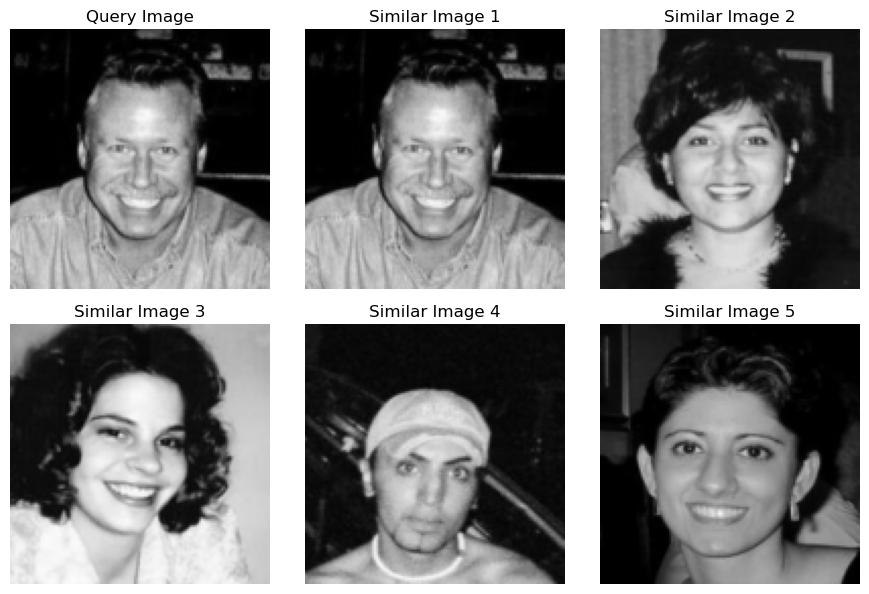

In [11]:
# 步骤1: 提取所有图像的特征
encoded_images = feat()


# 步骤2: 实现搜索函数
def find_similar_images(query_feature, features, top_k=5):
    similarities = [cosine_similarity(query_feature.reshape(1, -1), feature.reshape(1, -1)) for feature in features]
    # 获取最相似的图像的索引
    top_indices = np.argsort(similarities, axis=0)[-top_k:][::-1].flatten()
    return top_indices


# 显示图像的函数
def show_images(images, titles, cols=3):
    rows = len(images) // cols + 1
    plt.figure(figsize=(cols * 3, rows * 3))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        if img.ndim == 3 and img.shape[0] == 3:
            img = img.transpose(1, 2, 0)  # 将其转换为[H, W, C]格式
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# 步骤3: 检索相似图像
query_idx = 123
query_img = val_dataset[query_idx]
query_img = query_img.to(device)
query_feature = model.encoder(query_img.unsqueeze(0)).detach().cpu().numpy()
similar_indices = find_similar_images(query_feature, encoded_images)

# 显示查询图像和相似图像
query_img = original_images[query_idx]
similar_images = [original_images[idx] for idx in similar_indices]  
show_images([query_img] + similar_images,
            ['Query Image'] + [f'Similar Image {i + 1}' for i in range(len(similar_images))])

In [68]:
import datetime

# 获取当前日期和时间
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# 文件名使用当前日期和时间
filename = f'vgg16_UL_{current_time}.pth'

# 保存模型状态
torch.save(model.state_dict(), filename)

# 9 Conclusion

## Conclusions
This study successfully demonstrates the potential of a modified VGG16 autoencoder in the realm of unsupervised learning, specifically in the task of image feature extraction and similarity detection. By leveraging the entire GENKI-4K dataset, our model has shown remarkable proficiency in identifying subtle similarities among facial images, a testament to the effectiveness of deep neural networks in complex pattern recognition tasks.

## Future Improvements
The success of our current model and methodology in image similarity detection opens several avenues for future enhancements and research, promising even greater performance and applicability:

1. Hybrid Learning Approaches
Incorporating supervised learning components, particularly semi-supervised techniques, into our current unsupervised framework could significantly boost the accuracy and dependability of similarity detection. This hybrid approach allows the model to benefit from labeled data where available, potentially enhancing its learning capacity and predictive precision.
2. Expansion of Dataset Scope
To further validate and refine our model, it is crucial to test it across a broader range of datasets. Exploring larger and more diverse image collections will offer valuable insights into the model's scalability and its ability to adapt to various image types. This expansion is particularly important for transcending the niche of facial recognition and exploring the model's efficacy in broader image processing tasks.